# Siamese

Source: https://keras.io/examples/mnist_siamese/

In [1]:
import os
import h5py
from time import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import ipyvolume as ipv

import sys
sys.path.append("..") 
from cryoem.projections import RotationMatrix

import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

from tensorflow_graphics.util import shape
from tensorflow_graphics.geometry.transformation import quaternion, euler
from tensorflow_graphics.util import asserts
from tensorflow_graphics.math import vector
from tensorflow_graphics.util import safe_ops

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1012080098253180897
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5009200249935649727
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17880098084476752666
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 484007278703994514
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 5424383673271440011
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:3b:00.0, compute capability: 3.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_l

## Read data 

In [3]:
angle_ranges = "2.0,0.4,2.0"
angle_shift = "0.0,0.0,0.0"
num_projections = 5000
dir_name = "../data/"
projections_filename = f"5j0n_ProjectionsAngles_ProjNber{num_projections}_AngCoverage{angle_ranges}_AngShift{angle_shift}"


# load structures
data = h5py.File(os.path.join(dir_name, f"{projections_filename}.h5"), 'r')

X, y = data['Projections'], data['Angles']
print(f"{X.shape[0]} projections of images with dimension {X.shape[1:]} pixels")
print(f"{y.shape[0]} sets of {y.shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [4]:
# plot coverage
all_vectors = RotationMatrix(y)
ipv.figure(width=500, height=500)
ipv.pylab.xlim(-1, 1)
ipv.pylab.ylim(-1, 1)
ipv.pylab.zlim(-1, 1)
ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
ipv.pylab.save(f"data/angle_variety/{angle_ranges}.html")
ipv.show()

## Distances


#### Angle Distance

In [5]:
def euler2quaternion(angles):
    """
    Quaternion implements 3 rotations along x, y, z axis. 
    We compose them to get the final (single) rotation.
    """
    with tf.compat.v1.name_scope(None, "quaternion_from_euler", [angles]):
        #print(angles)
        a = [angles[i] for i in range(len(angles))]

        a = tf.convert_to_tensor(value=a)

        shape.check_static(tensor=a, tensor_name="angles", has_dim_equals=(-1, 3))

        half_angles = a / 2.0
        cos_half_angles = tf.cos(half_angles)
        sin_half_angles = tf.sin(half_angles)
        c1, c2, c3 = tf.unstack(cos_half_angles, axis=-1)
        s1, s2, s3 = tf.unstack(sin_half_angles, axis=-1)
        # Tait-Bryan angles
        #w = c1 * c2 * c3 + s1 * s2 * s3
        #x = -c1 * s2 * s3 + s1 * c2 * c3
        #y = c1 * s2 * c3 + s1 * c2 * s3
        #z = -s1 * s2 * c3 + c1 * c2 * s3
        
        # Euler angles
        w = c1*c2*c3 - s1*c2*s3
        x = c1*s2*s3 - s1*s2*c3
        y = c1*s2*c3 + s1*s2*s3
        z = c1*c2*s3 + s1*c2*c3
        return tf.stack((x, y, z, w), axis=-1)

def d_q(q1, q2):
     with (tf.compat.v1.name_scope(None, "quaternion_relative_angle",[q1, q2])):
        q1 = tf.convert_to_tensor(value=q1)
        q2 = tf.convert_to_tensor(value=q2)
      
        shape.check_static(
            tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4))
        shape.check_static(
            tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))

        q1 = quaternion.normalize(q1)
        q2 = quaternion.normalize(q2)
        
        dot_product = vector.dot(q1, q2, keepdims=False)
        
        # Ensure dot product is in range [-1. 1].
        const = 1.8 #4.0 #.63
        eps_dot_prod = const * asserts.select_eps_for_addition(dot_product.dtype)
        dot_product = safe_ops.safe_shrink(
            dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

        return 2.0 * tf.acos(tf.abs(dot_product)) 

In [6]:
assert (d_q(euler2quaternion([np.pi/2]*3), euler2quaternion([2*np.pi-np.pi/2]*3))-np.pi) < 1e-7

#### Projection Distance

In [7]:
def d_p(p1, p2):
    # (learned) distance between two images.
    # for now, Euclid dist
    p1 = tf.convert_to_tensor(value=p1, dtype=np.float64)
    p2 = tf.convert_to_tensor(value=p2, dtype=np.float64)

    if len(p1.shape) > 1:
        dist = tf.norm(p1-p2, ord='euclidean', axis=1, keepdims=True)
    else:
        dist = tf.norm(p1-p2, ord='euclidean')

    return dist

In [8]:
assert tf.reduce_mean(d_p(X[0:3], X[0:3])) < 1e-7

---

## kNN of the Projections

In [9]:
k = 5

In [10]:
def get_knn_output(k):
    start_time = time()

    _X = np.reshape(X, (X.shape[0], -1))
    
    name = projections_filename.split('/')[-1]
    if not os.path.exists(f'data/knn{k}_{name}_distances.npy'):
        nbrs = NearestNeighbors(n_neighbors=k, metric=d_p, algorithm='ball_tree', n_jobs=-1).fit(_X)
        distances_p, indices_p = nbrs.kneighbors(_X)
        A_p = nbrs.kneighbors_graph(_X).toarray()

        try:
            np.save(f'data/knn{k}_{name}_indices', indices_p)         # Indices of the nearest points in the population matrix
            np.save(f'data/knn{k}_{name}_distances', distances_p)     # Array representing the lengths to points
            np.save(f'data/knn{k}_{name}_A', A_p)                     # Sparse graph showing the connections between neighboring points
        except:
            pass
        print(f"--- {time() - start_time} seconds ---")
    
    else:
        indices_p     = np.load(f'data/knn{k}_{name}_indices.npy')     # shape: NUM_IMGS, NUM_NEIGHBOURS
        distances_p   = np.load(f'data/knn{k}_{name}_distances.npy')   # shape: NUM_IMGS, NUM_NEIGHBOURS
        A_p           = np.load(f'data/knn{k}_{name}_A.npy')           # shape: NUM_IMGS, NUM_IMGS

    
    return indices_p, distances_p, A_p 

In [11]:
# --- 23594.572999954224 seconds ---
indices_p, distances_p, A_p = get_knn_output(k=k)

In [12]:
np.max(distances_p)

63.95002548806251

---

## Prepare for training

In [44]:
def sample_pairs(num_projections, num_pairs, style="random", k=None):
    if not k and style != "random":
        raise ValueError("Please specify k for kNN for sample_pairs method")
    
    if style=="random":
        idx1 = list(np.random.randint(0, num_projections, num_pairs))
        idx2 = list(np.random.randint(0, num_projections, num_pairs))
    
    elif style=="knn":
        idx1 = list(np.random.randint(0, num_projections, num_pairs))
        indices_p, distances_p, A_p = get_knn_output(k=k)
        idx2 = [indices_p[i][np.random.randint(1, k)] for i in idx1]
 
    elif style=="knn_and_random":
        # select random sample for the first element of pair
        idx1 = list(np.random.randint(0, num_projections, num_pairs))
        
        # half from kNN
        indices_p, distances_p, A_p = get_knn_output(k=k)
        idx2_knn = [indices_p[i][np.random.randint(1, k)] for i in idx1[:num_pairs//2]]
        idx2_random = list(np.random.randint(0, num_projections, num_pairs//2))
        # half random
        idx2 = idx2_knn + idx2_random
        
    return idx1, idx2

In [45]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    return  K.mean(K.square(y_pred - y_true))

def create_pairs(x, y, num_pairs):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    
    # Sample some pairs.
    idx1, idx2 = sample_pairs(num_projections=NUM_PROJECTIONS, num_pairs=num_pairs, style="knn", k=k)
    
    for z1, z2 in zip(idx1, idx2):
        pairs += [[x[z1], x[z2]]]
        labels += [d_q(euler2quaternion(y[z1]), euler2quaternion(y[z2]))]

    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_x = Input(shape=input_shape)
    print(input_x)
    
    # add Convolution, MaxPool, Conv2D, remove Dropout and Dense
    x = Conv2D(filters=32, kernel_size=[7, 7], activation='relu', padding='same', kernel_initializer='glorot_uniform')(input_x)
    print(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    print(x)
    
    x = Conv2D(64, [5, 5], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    print(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    print(x)
    
    x = Conv2D(128, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    print(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    print(x)
    
    x = Conv2D(256, [1, 1], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    print(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    print(x)
    
    x = Conv2D(1, [1, 1], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    print(x)

    x = AvgPool2D(pool_size=[8, 8], padding='same')(x)
    print(x)
    #x = Flatten()(x)
    
    return Model(input_x, x)


# def accuracy(y_true, y_pred):
#     '''Compute classification accuracy with a fixed threshold on distances.
#     '''
#     y_pred = K.flatten(y_pred)

#     return K.mean(K.square(y_pred - y_true) < ACCURACY_THRESHOLD)

gloabal average pooling - width and hights OR 
flatten

Pooling - shrinks in space

In [46]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    y_pred = K.flatten(y_pred)

    return K.mean(K.square(y_pred - y_true) < ACCURACY_THRESHOLD)

## Training

In [47]:
EPOCHS = 10
BATCH_SIZE = 256
ACCURACY_THRESHOLD = 1e-6
NUM_PROJECTIONS = 5000

In [49]:
# the data, split between train and test sets
train_idx, test_idx, _, _ = train_test_split(range(len(X)), range(len(y)), test_size=0.33, random_state=42)
train_idx = sorted(train_idx)
test_idx = sorted(test_idx)

X_data, y_data = create_pairs(X, y, 6000)

tr_pairs, tr_y = X_data[train_idx], y_data[train_idx]
tr_pairs = tr_pairs.reshape(list(tr_pairs.shape) + [-1])
tr_y = tf.cast(tr_y, dtype=tf.float32)

te_pairs, te_y = X_data[test_idx], y_data[test_idx]
te_pairs = te_pairs.reshape(list(te_pairs.shape) + [-1])
te_y = tf.cast(te_y, dtype=tf.float32)

In [50]:
input_shape = list(te_pairs[:, 0].shape[1:])
print(f"Input images shape {input_shape}")

Input images shape [116, 116, 1]


In [51]:
X_train.shape

(3350, 116, 116)

In [52]:
tr_pairs.shape

(3350, 2, 116, 116, 1)

In [53]:
te_pairs[:, 0].shape

(1650, 116, 116, 1)

In [54]:
te_y.shape

TensorShape([1650])

---

0.15 loss, 0.0017 acc

test set
plot train and test losses

In [55]:
# network definition
base_network = create_base_network(input_shape)


input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)



# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)



distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])


model = Model([input_a, input_b], distance)


# train
rms = RMSprop()


model.compile(loss=loss, optimizer=rms, metrics=None)  #[accuracy])


model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))



Tensor("input_1:0", shape=(None, 116, 116, 1), dtype=float32)
Tensor("conv2d/Identity:0", shape=(None, 116, 116, 32), dtype=float32)
Tensor("max_pooling2d/Identity:0", shape=(None, 58, 58, 32), dtype=float32)
Tensor("conv2d_1/Identity:0", shape=(None, 58, 58, 64), dtype=float32)
Tensor("max_pooling2d_1/Identity:0", shape=(None, 29, 29, 64), dtype=float32)
Tensor("conv2d_2/Identity:0", shape=(None, 29, 29, 128), dtype=float32)
Tensor("max_pooling2d_2/Identity:0", shape=(None, 15, 15, 128), dtype=float32)
Tensor("conv2d_3/Identity:0", shape=(None, 15, 15, 256), dtype=float32)
Tensor("max_pooling2d_3/Identity:0", shape=(None, 8, 8, 256), dtype=float32)
Tensor("max_pooling2d_4/Identity:0", shape=(None, 4, 4, 1), dtype=float32)
Tensor("average_pooling2d/Identity:0", shape=(None, 1, 1, 1), dtype=float32)
Train on 3350 samples, validate on 1650 samples
Epoch 1/10
3350/3350 [==============================] - 13s 4ms/sample - loss: 3.5853 - val_loss: 1.7740
Epoch 2/10
3350/3350 [===============

In [56]:
# compute final accuracy on training and test sets
y_tr_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_tr_pred)
print(f'* Accuracy on training set: {(100 * tr_acc):.2f}%')

* Accuracy on training set: 0.06%


In [58]:
y_te_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_te_pred)
print(f'* Accuracy on test set: {(100 * te_acc):.2f}%')

* Accuracy on test set: 0.12%


In [62]:
te_pairs = te_pairs.reshape(list(te_pairs.shape[:-2]) +[-1])
tr_pairs = tr_pairs.reshape(list(tr_pairs.shape[:-2]) +[-1])

(1650, 2, 116, 116)

--- Test Set ---
loss:      1.896526575088501
predicted: 1.6445937156677246
true:      3.021738052368164


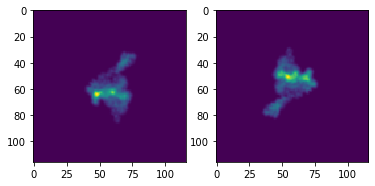

In [84]:
plt.imfig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(te_pairs[2, 0])
ax2.imshow(te_pairs[2, 1])
print(f"--- Test Set ---")
print(f"loss:      {loss(y_te_pred[2], te_y[2].numpy())}")
print(f"predicted: {y_te_pred[2][0][0][0]}")
print(f"true:      {te_y[2].numpy()}")

--- Train Set ---
loss:      5.903715133666992
predicted: 0.3277754783630371
true:      2.7575316429138184


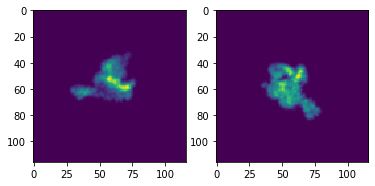

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(tr_pairs[2, 0])
ax2.imshow(tr_pairs[2, 1])
print(f"--- Train Set ---")
print(f"loss:      {loss(y_tr_pred[0], tr_y[0].numpy())}")
print(f"predicted: {y_tr_pred[0][0][0][0]}")
print(f"true:      {tr_y[0].numpy()}")